In [1]:
import pulse2percept as p2p
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.axes import Subplot
from matplotlib.animation import FuncAnimation
from math import isclose
from scipy.cluster.vq import kmeans2
import imageio
import logging
from skimage import img_as_uint
from skimage.transform import resize

In [2]:
from math import isclose

VIDEO_BLOCK_SIZE = 16
def save(self, fname, shape=None, fps=None):
  data = self.data - self.data.min()
  if not isclose(np.max(data), 0):
      data = data / np.max(data)
  data = img_as_uint(data)

  if shape is None:
      # Use 320px width and infer height from aspect ratio:
      shape = (None, 320)
  height, width = shape
  if height is None and width is None:
      raise ValueError('If shape is a tuple, must specify either height '
                        'or width or both.')
  # Infer height or width if necessary:
  if height is None and width is not None:
      height = width / self.data.shape[1] * self.data.shape[0]
  elif height is not None and width is None:
      width = height / self.data.shape[0] * self.data.shape[1]
  # Rescale percept to desired shape:
  #data = resize(data, (np.int32(height), np.int32(width)))

  if self.time is None:
      # No time component, store as an image. imwrite will automatically
      # scale the gray levels:
      imageio.imwrite(fname, img_as_uint(data))
  else:
      # With time component, store as a movie:
      if fps is None:
          interval = unique(np.diff(self.time))
          if len(interval) > 1:
              raise NotImplementedError
          fps = 1000.0 / interval[0]
      # Note, for most codecs, the image dimensions must be divisible by
      # 16 the default for the VIDEO_BLOCK_SIZE is 16. Check if image is
      # divisible, if not have ffmpeg upsize to nearest size and warn
      # user they should correct input image if this is not desired.
      h, w = data.shape[:2]
      if VIDEO_BLOCK_SIZE > 1:
          if h % VIDEO_BLOCK_SIZE > 0 or w % VIDEO_BLOCK_SIZE > 0:
              out_h, out_w = h, w
              if w % VIDEO_BLOCK_SIZE > 0:
                  out_w += VIDEO_BLOCK_SIZE - (w % VIDEO_BLOCK_SIZE)
              if h % VIDEO_BLOCK_SIZE > 0:
                  out_h += VIDEO_BLOCK_SIZE - (h % VIDEO_BLOCK_SIZE)
              data = resize(data, (out_h, out_w))
      data = img_as_uint(data).astype(np.uint8)
      imageio.mimwrite(fname, data.transpose((2, 0, 1)), fps=fps)
  logging.getLogger(__name__).info(f'Created {fname}.')

In [3]:
model_score = p2p.models.ScoreboardSpatial(xrange=(-16,16), yrange=(-16,16), rho=70)
model_score.build()

ScoreboardSpatial(engine=None, grid_type='rectangular', 
                  n_gray=None, n_jobs=1, n_threads=16, 
                  noise=None, retinotopy=Watson2014Map, 
                  rho=70, scheduler='threading', 
                  thresh_percept=0, verbose=True, 
                  xrange=(-16, 16), xystep=0.25, 
                  yrange=(-16, 16))

In [4]:
#method that creates phosphenes
def phosphenes(image):
  logo = p2p.stimuli.ImageStimulus(image)
  grid_sizes = [(32,32)]
  implant_new = {};
  for gsize in grid_sizes:
      spacing = 280
      radius =  35
      egrid = p2p.implants.ElectrodeGrid(gsize, spacing,
                                        etype=p2p.implants.DiskElectrode,
                                        r=radius)
      implant_new = p2p.implants.ProsthesisSystem(egrid)


  implant_new.stim= logo.resize(implant_new.earray.shape)
  percept2 = model_score.predict_percept(implant_new)
  save(percept2,'temp.jpg')  
  image = skimage.io.imread('temp.jpg')
  image = cv2.resize(image, (1000, 1000)) 
  cv2.imwrite('temp.jpg', image)
  return image

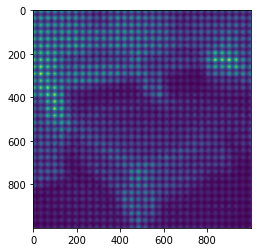

In [10]:
import skimage
image = skimage.io.imread('IMG_1081.jpg')

#testing phosphene implementations works
p=phosphenes(image)
plt.imshow(p)

In [8]:
import cv2
import numpy as np
# Load the model

# Load the model
net = cv2.dnn.readNetFromTensorflow("frozen_inference_graph_coco.pb",
      "mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")

# Store Coco names in a list
classesFile = "coco.names"
classNames = open(classesFile).read().strip().split('\n')

import cv2


vc = cv2.VideoCapture(1)

if vc.isOpened(): # try to get the first frame
    rval, img = vc.read()
else:
    rval = False

alpha=1
while rval:
    rval, img = vc.read()
    key = cv2.waitKey(20)
    height, width, _ = img.shape

##Direct Implementation
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray= phosphenes(gray)
    gray = cv2.resize(gray, (320, 320)) 
    img1 = np.zeros((650,650), np.uint8)*255

   # Select the region in the background where we want to add the image and add the images using cv2.addWeighted()
    added_image = cv2.addWeighted(gray[0:320,0:320],alpha,img1[0:320,0:320],1-alpha,0)

    # Change the region with the result
    img1[150:470,150:470] = added_image
    cv2.imshow("Black image", img1)
    cv2.moveWindow("Black image", 650,200)

##Enhancement Implementation starts here  (leave the Direct section above uncommented)
########################################################################################################################

    # Create black image
    blank_mask = np.zeros((height, width, 3), np.uint8)
    blank_mask[:] = (0, 0, 0)

    # Create blob from the image
    blob = cv2.dnn.blobFromImage(img, swapRB=True)

    # Detect objects
    net.setInput(blob)

    boxes, masks = net.forward(["detection_out_final", "detection_masks"])
    detection_count = boxes.shape[2]
    #print(detection_count)
    count = 0
    for i in range(detection_count):
        # Extract information from detection
        box = boxes[0, 0, i]
        class_id = int(box[1])
        score = box[2]
        # print(class_id, score)
        if score < 0.6:
            continue

        # print(class_id)
        class_name = (classNames[class_id])
        # print(class_name, score)
        x = int(box[3] * width)
        y = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)

        roi = blank_mask[y: y2, x: x2]
        roi_height, roi_width, _ = roi.shape
        
        # Get the mask
        mask = masks[i, int(class_id)]
        mask = cv2.resize(mask, (roi_width, roi_height))
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)
        # cv2.imshow("mask"+str(count), mask)
        count+=1
        # Find contours of the mask
        contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        color = np.random.randint(254, 255, 3, dtype='uint8')
        color = [int(c) for c in color]

        # fill some color in segmented area
        for cnt in contours:
            cv2.fillPoly(roi, [cnt], (int(color[0]), int(color[1]), int(color[2])))
            # cv2.imshow("roi", roi)
            
        # Draw bounding box
        cv2.rectangle(img, (x, y), (x2, y2), color, 2)
        cv2.putText(img, class_name + " " + str(score), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1)
        
    # alpha is the transparency of the first picture
    alpha = 1
    # beta is the transparency of the second picture
    beta = 0.8
    mask_img = cv2.addWeighted(img, alpha, blank_mask, beta, 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    dilate = cv2.dilate(blank_mask, kernel, iterations=3)
    result = cv2.bitwise_and(img, dilate)
    gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(gray, [c], -1, (255,255,255), thickness=6)

    # Enhance image contrast
    gray = cv2.equalizeHist(gray)

    #gray = cv2.resize(gray, (320, 320)) 
    gray= phosphenes(gray)
    gray = cv2.resize(gray, (320, 320)) 
    img1 = np.zeros((650,650), np.uint8)*255

   # Select the region in the background where we want to add the image and add the images using cv2.addWeighted()
    added_image = cv2.addWeighted(gray[0:320,0:320],alpha,img1[0:320,0:320],1-alpha,0)

    # Change the region with the result
    img1[150:470,150:470] = added_image
    cv2.imshow("Black image", img1)
    cv2.moveWindow("Black image", 650,200)  
########################################################################################################################

    if key == 27: # exit on ESC
      break

vc.release()
cv2.destroyWindow("Black image")

In [9]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.
